In [1]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
# Path untuk folder train dan test
train_path = '/kaggle/input/data-slayer/train'
test_path = '/kaggle/input/data-slayer/test'

## Load Dataset

In [3]:
import os
import cv2
import shutil

# Fungsi untuk menyimpan gambar ke subfolder fall dan non fall
def save_images_to_folders(train_path, output_folder='output_images'):
    os.makedirs(output_folder, exist_ok=True)  # Membuat folder output utama jika belum ada

    for subject_folder in os.listdir(train_path):
        subject_path = os.path.join(train_path, subject_folder)
        if os.path.isdir(subject_path):
            for fall_or_non_fall in os.listdir(subject_path):
                fall_or_non_fall_path = os.path.join(subject_path, fall_or_non_fall)
                if os.path.isdir(fall_or_non_fall_path):

                    # Buat subfolder fall atau non fall di dalam output_folder
                    output_subfolder = os.path.join(output_folder, fall_or_non_fall)
                    os.makedirs(output_subfolder, exist_ok=True)

                    for class_folder in os.listdir(fall_or_non_fall_path):
                        class_path = os.path.join(fall_or_non_fall_path, class_folder)
                        if os.path.isdir(class_path):
                            for image_file in os.listdir(class_path):
                                if image_file.lower().endswith(('.jpg', '.jpeg', '.png')):  # Filter file gambar
                                    image_path = os.path.join(class_path, image_file)

                                    # Salin gambar ke output_subfolder
                                    output_image_path = os.path.join(output_subfolder, f"{subject_folder}_{class_folder}_{image_file}")
                                    shutil.copy(image_path, output_image_path)

    print("Semua gambar berhasil disalin ke folder 'fall' dan 'non fall'!")


# Panggil fungsi untuk menyimpan gambar
save_images_to_folders(train_path, output_folder='data')


Semua gambar berhasil disalin ke folder 'fall' dan 'non fall'!


In [4]:
from datasets import load_dataset

# Loading the dataset from the local directory
dataset = load_dataset('data', data_dir='')

print(dataset)

Resolving data files:   0%|          | 0/4294 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 4294
    })
})


**rename features "label" ke "labels" karena model ViTForImageClassification mengharapkan argumen dengan nama labels**

In [5]:
from datasets import DatasetDict

dataset = dataset.rename_column("label", "labels")

**Split data**

In [6]:
dataset = dataset["train"].train_test_split(test_size=0.2)

**Melihat contoh photo dalam data**

In [7]:
labels = dataset['train'].features['labels']
print(labels)

ClassLabel(names=['fall', 'non_fall'], id=None)


In [8]:
ex = dataset['train'][20]
ex

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1280x720>,
 'labels': 1}

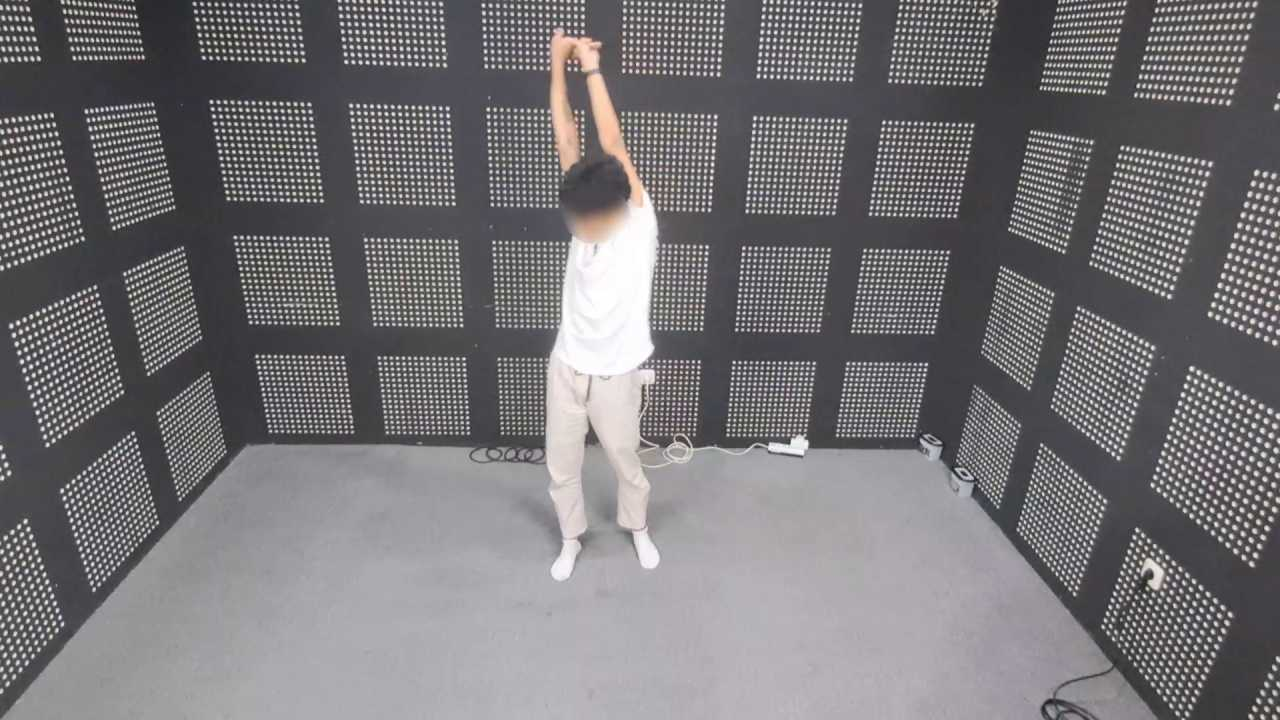

In [9]:
image = ex['image']
image

In [10]:
labels.int2str(ex['labels'])

'non_fall'

**Membuat fungsi untuk melihat beberapa contoh data beserta nama kelasnya**

Filter:   0%|          | 0/3435 [00:00<?, ? examples/s]

Filter:   0%|          | 0/3435 [00:00<?, ? examples/s]

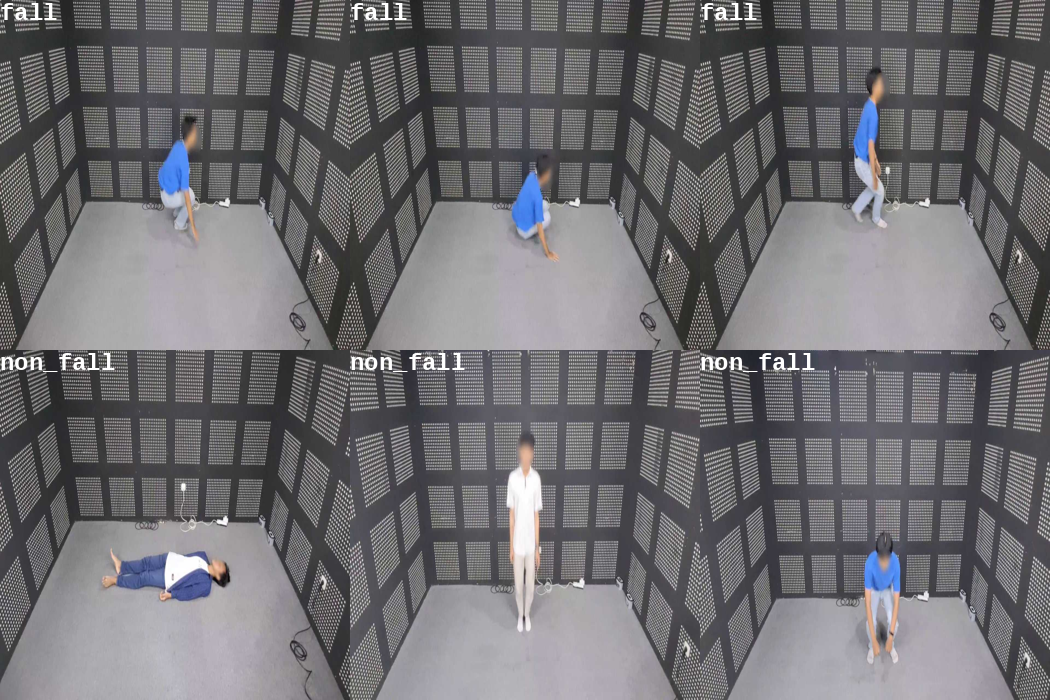

In [11]:
import random
from PIL import ImageDraw, ImageFont, Image

def show_examples(ds, seed: int = 1234, examples_per_class: int = 3, size=(350, 350)):

    w, h = size
    labels = ds['train'].features['labels'].names
    grid = Image.new('RGB', size=(examples_per_class * w, len(labels) * h))
    draw = ImageDraw.Draw(grid)
    font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationMono-Bold.ttf", 24)

    for label_id, label in enumerate(labels):

        # Filter the dataset by a single label, shuffle it, and grab a few samples
        ds_slice = ds['train'].filter(lambda ex: ex['labels'] == label_id).shuffle(seed).select(range(examples_per_class))

        # Plot this label's examples along a row
        for i, example in enumerate(ds_slice):
            image = example['image']
            idx = examples_per_class * label_id + i
            box = (idx % examples_per_class * w, idx // examples_per_class * h)
            grid.paste(image.resize(size), box=box)
            draw.text(box, label, (255, 255, 255), font=font)

    return grid

show_examples(dataset, seed=random.randint(0, 1337), examples_per_class=3)

## Loading ViT Image Processor

Ketika model ViT dilatih, transformasi khusus diterapkan pada gambar yang dimasukkan ke dalamnya. Jika Anda menggunakan transformasi yang salah pada gambar Anda, model tidak akan memahami apa yang dilihatnya! 🖼 ➡️ 🔢

Untuk memastikan kita menerapkan transformasi yang benar, kita akan menggunakan **ViTImageProcessor** yang diinisialisasi dengan konfigurasi yang disimpan bersama model pralatih yang akan kita gunakan. Dalam kasus ini, kita akan menggunakan model **google/vit-base-patch16-224-in21k**, jadi mari kita muat image processor-nya dari **Hugging Face Hub**.

In [12]:
from transformers import AutoImageProcessor

checkpoint = "google/vit-base-patch16-224-in21k"
img_processor = AutoImageProcessor.from_pretrained(checkpoint)

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


In [13]:
img_processor(image, return_tensors='pt')

{'pixel_values': tensor([[[[-0.4824, -0.4431, -0.4196,  ..., -0.4353, -0.4431, -0.4431],
          [-0.2941, -0.3176, -0.3412,  ..., -0.4275, -0.4353, -0.4275],
          [ 0.0510,  0.0667,  0.0902,  ..., -0.4196, -0.4275, -0.4275],
          ...,
          [-0.3412, -0.0353,  0.1451,  ..., -0.1765, -0.3333, -0.2000],
          [-0.1922,  0.1059,  0.1686,  ..., -0.2314, -0.2314, -0.2000],
          [ 0.0118,  0.1451,  0.1843,  ..., -0.0588, -0.1294,  0.0824]],

         [[-0.4824, -0.4431, -0.4275,  ..., -0.4431, -0.4431, -0.4431],
          [-0.2941, -0.3176, -0.3490,  ..., -0.4353, -0.4353, -0.4275],
          [ 0.0510,  0.0667,  0.0824,  ..., -0.4275, -0.4275, -0.4275],
          ...,
          [-0.3412, -0.0353,  0.1451,  ..., -0.2078, -0.3647, -0.2314],
          [-0.1922,  0.1059,  0.1686,  ..., -0.2627, -0.2627, -0.2314],
          [ 0.0118,  0.1451,  0.1843,  ..., -0.0902, -0.1608,  0.0510]],

         [[-0.4824, -0.4431, -0.4275,  ..., -0.4353, -0.4431, -0.4431],
          [-0

## Processing the Dataset  

**a. Preprocessing Gambar**  
- **`img_processor`**: Objek preprocessing (seperti dari transformers.ImageProcessor) yang menyiapkan gambar untuk dimasukkan ke dalam model.  
- **`example['image']`**: Gambar dari dataset dalam format seperti PIL.Image, numpy array, atau tensor.  
- **`return_tensors='pt'`**: Mengubah gambar menjadi tensor PyTorch (pt singkatan dari PyTorch). Tensor ini digunakan sebagai input untuk model machine learning.

**b. Menambah Label**  
- **`example['labels']`**: Label dari gambar dalam dataset (misalnya, 0 untuk "kucing", 1 untuk "anjing").
- Menambahkan label ke dalam dictionary `inputs` untuk digunakan dalam pelatihan model.

**c. Return hasil**  
- Dictionary berisi input gambar yang sudah diproses (`inputs`) dan labelnya.

In [14]:
def process_example(example):
    inputs = img_processor(example['image'], return_tensors='pt')
    inputs['labels'] = example['labels']
    return inputs

In [15]:
process_example(dataset['train'][0])

{'pixel_values': tensor([[[[-0.4980, -0.5529, -0.6078,  ..., -0.5294, -0.5294, -0.5294],
          [-0.1137, -0.1608, -0.3333,  ..., -0.5294, -0.5294, -0.5294],
          [-0.2549, -0.0980, -0.0118,  ..., -0.5373, -0.5294, -0.5294],
          ...,
          [-0.0902, -0.1216, -0.0039,  ..., -0.4275, -0.5373, -0.5451],
          [-0.2627, -0.2157, -0.2471,  ..., -0.3020, -0.5451, -0.5608],
          [-0.2784,  0.1137, -0.1843,  ..., -0.4275, -0.5451, -0.5608]],

         [[-0.4980, -0.5529, -0.6078,  ..., -0.5373, -0.5373, -0.5373],
          [-0.1137, -0.1608, -0.3333,  ..., -0.5373, -0.5373, -0.5373],
          [-0.2549, -0.0980, -0.0118,  ..., -0.5451, -0.5373, -0.5373],
          ...,
          [-0.0902, -0.1216, -0.0039,  ..., -0.4275, -0.5373, -0.5451],
          [-0.2627, -0.2157, -0.2471,  ..., -0.3020, -0.5451, -0.5608],
          [-0.2784,  0.1137, -0.1843,  ..., -0.4275, -0.5451, -0.5608]],

         [[-0.4980, -0.5529, -0.6078,  ..., -0.4980, -0.4980, -0.4980],
          [-0

In [16]:
def transform(example_batch):
    # Take a list of PIL images and turn them to pixel values
    inputs = img_processor([x for x in example_batch['image']], return_tensors='pt')

    # Don't forget to include the labels!
    inputs['labels'] = example_batch['labels']
    return inputs

In [17]:
prepared_ds = dataset.with_transform(transform)

In [18]:
prepared_ds['test'][0:2]

{'pixel_values': tensor([[[[-0.0980, -0.0431, -0.0431,  ..., -0.4353, -0.4196, -0.4118],
          [-0.4824, -0.4431, -0.4588,  ..., -0.1765, -0.1216, -0.1608],
          [-0.3804, -0.3569, -0.4118,  ...,  0.0039,  0.0745,  0.0510],
          ...,
          [-0.4667, -0.4431, -0.4510,  ..., -0.5765, -0.5451, -0.0118],
          [-0.4824, -0.4824, -0.4745,  ..., -0.5686, -0.4118, -0.3490],
          [-0.4824, -0.4902, -0.4902,  ..., -0.5608, -0.1373, -0.1608]],

         [[-0.0980, -0.0431, -0.0431,  ..., -0.4353, -0.4196, -0.4118],
          [-0.4824, -0.4431, -0.4588,  ..., -0.1765, -0.1216, -0.1608],
          [-0.3804, -0.3569, -0.4118,  ...,  0.0039,  0.0745,  0.0510],
          ...,
          [-0.4667, -0.4431, -0.4510,  ..., -0.6078, -0.5765, -0.0431],
          [-0.4824, -0.4824, -0.4824,  ..., -0.6000, -0.4431, -0.3804],
          [-0.4824, -0.4902, -0.4980,  ..., -0.5922, -0.1686, -0.1922]],

         [[-0.0980, -0.0431, -0.0431,  ..., -0.4353, -0.4196, -0.4118],
          [-0

In [19]:
prepared_ds['train'][0:12]

{'pixel_values': tensor([[[[-0.4980, -0.5529, -0.6078,  ..., -0.5294, -0.5294, -0.5294],
          [-0.1137, -0.1608, -0.3333,  ..., -0.5294, -0.5294, -0.5294],
          [-0.2549, -0.0980, -0.0118,  ..., -0.5373, -0.5294, -0.5294],
          ...,
          [-0.0902, -0.1216, -0.0039,  ..., -0.4275, -0.5373, -0.5451],
          [-0.2627, -0.2157, -0.2471,  ..., -0.3020, -0.5451, -0.5608],
          [-0.2784,  0.1137, -0.1843,  ..., -0.4275, -0.5451, -0.5608]],

         [[-0.4980, -0.5529, -0.6078,  ..., -0.5373, -0.5373, -0.5373],
          [-0.1137, -0.1608, -0.3333,  ..., -0.5373, -0.5373, -0.5373],
          [-0.2549, -0.0980, -0.0118,  ..., -0.5451, -0.5373, -0.5373],
          ...,
          [-0.0902, -0.1216, -0.0039,  ..., -0.4275, -0.5373, -0.5451],
          [-0.2627, -0.2157, -0.2471,  ..., -0.3020, -0.5451, -0.5608],
          [-0.2784,  0.1137, -0.1843,  ..., -0.4275, -0.5451, -0.5608]],

         [[-0.4980, -0.5529, -0.6078,  ..., -0.4980, -0.4980, -0.4980],
          [-0

## Augmentasi Data  

Kode ini digunakan untuk menerapkan augmentasi pada dataset gambar dengan menggunakan pustaka `torchvision.transforms`. Augmentasi membantu meningkatkan keragaman data pelatihan, sehingga model lebih robust terhadap variasi data.

#### Penjelasan Komponen:
1. **Augmentasi yang Didefinisikan**:
   - `RandomHorizontalFlip(p=0.5)`: Membalik gambar secara horizontal dengan probabilitas 50%.
   - `RandomAffine(degrees=0, translate=(0.3, 0.3))`: Menerapkan transformasi afine, di mana gambar dapat digeser hingga 30% dari dimensinya.
   - `ColorJitter(...)`: Mengubah kecerahan, kontras, saturasi, dan hue gambar secara acak.

2. **Fungsi `augment_batch`**:
   - Fungsi ini menerima batch dari dataset dan menerapkan augmentasi pada setiap gambar dalam batch menggunakan fungsi augmentasi yang didefinisikan sebelumnya.

3. **Pemrosesan Dataset**:
   - `map(...)`: Menerapkan fungsi `augment_batch` ke dataset split `train` dalam mode batch.
   - `batched=True`: Data diproses dalam batch untuk efisiensi.
   - `batch_size=32`: Setiap batch terdiri dari 32 contoh.
   - `num_proc=1`: Hanya menggunakan satu proses untuk pemrosesan data.


In [20]:
from datasets import load_dataset
from torchvision.transforms import (
    RandomHorizontalFlip, RandomAffine, RandomRotation, ColorJitter, Compose, ToTensor
)

# Definisikan augmentasi
augmentations = Compose([
    RandomHorizontalFlip(p=0.5),
    RandomAffine(degrees=0, translate=(0.3, 0.3)),
    # RandomRotation(degrees=15),
    ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
])

def augment_batch(dataset):
    images = [augmentations(image) for image in dataset['image']]
    return {'image': images}

dataset['train'] = dataset['train'].map(augment_batch, batched=True, batch_size=32, num_proc=1)


Map:   0%|          | 0/3435 [00:00<?, ? examples/s]

## Visualisasi Gambar Dataset yang Telah Di-augmentasi

#### Penjelasan Komponen:
1. **Library yang Digunakan**:
   - `matplotlib.pyplot`: Untuk menampilkan gambar.
   - `torchvision.transforms.ToTensor`: Untuk mengonversi gambar menjadi tensor sebelum divisualisasikan.
   - `numpy`: Untuk manipulasi array numerik.

2. **Mengambil Sampel Dataset**:
   - `dataset['train'][:5]`: Mengambil 5 contoh pertama dari dataset augmented.

3. **Proses Visualisasi**:
   - Gambar dalam format PIL diubah menjadi tensor menggunakan `ToTensor`.
   - Tensor diubah ke format gambar standar (HWC) menggunakan `permute(1, 2, 0)`.
   - Nilai gambar dijepit antara 0 dan 1 menggunakan `np.clip` agar dapat divisualisasikan dengan benar.

4. **Plot Gambar**:
   - `plt.subplots(1, 5, figsize=(15, 5))`: Membuat plot dengan 1 baris dan 5 kolom.
   - `axes[i].imshow(...)`: Menampilkan setiap gambar pada subplot.
   - `axes[i].axis('off')`: Menyembunyikan axis agar gambar terlihat lebih bersih.

5. **Menampilkan Hasil**:
   - `plt.show()`: Menampilkan semua gambar di jendela plot.


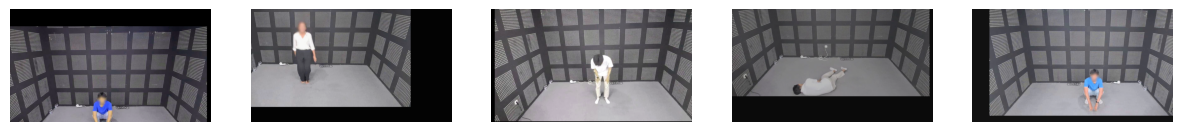

In [21]:
import matplotlib.pyplot as plt
import numpy as np
from torchvision.transforms import ToTensor

# Inisialisasi transformasi untuk mengonversi gambar menjadi tensor
to_tensor = ToTensor()

# Ambil beberapa contoh dari dataset yang sudah di-augmentasi
sample = dataset['train'][:5]  # Ambil 5 gambar pertama dari dataset yang sudah di-augmentasi

# Tampilkan gambar-gambar tersebut
fig, axes = plt.subplots(1, 5, figsize=(15, 5))

for i, example in enumerate(sample['image']):
    # Konversi gambar PIL ke tensor
    img_tensor = to_tensor(example)
    img = img_tensor.permute(1, 2, 0).numpy()  # Convert CHW -> HWC
    axes[i].imshow(np.clip(img, 0, 1))  # Pastikan nilai gambar berada di antara 0 dan 1
    axes[i].axis('off')  # Menyembunyikan axis

plt.show()


## Menentukan Data Collator

Batch data yang masuk berupa daftar dari dictionary. Anda dapat membongkar (unpack) dan menyusun ulang (stack) data tersebut menjadi tensor batch.

Karena fungsi **`collate_fn`** akan mengembalikan batch dalam bentuk dictionary, Anda bisa **membongkar (unpack) input ke dalam model di tahap berikutnya.**


#### Penjelasan:
1. **`pixel_values`**: Menggabungkan nilai piksel dari setiap elemen batch menjadi tensor menggunakan `torch.stack`.
2. **`labels`**: Menggabungkan label dari setiap elemen batch menjadi tensor menggunakan `torch.tensor`.
3. **Hasilnya**: Sebuah dictionary dengan tensor untuk fitur (`pixel_values`) dan label (`labels`). 

Collator ini memastikan data siap untuk diberikan ke model dalam format batch.

In [22]:
import torch

def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([x['labels'] for x in batch])
    }

In [23]:
!pip install evaluate

/usr/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 3.0 MB/s eta 0:00:00


## Menentukan Metrik Evaluasi

Metrik **akurasi** dari pustaka *datasets* dapat digunakan untuk membandingkan prediksi model dengan label. Berikut ini adalah cara menggunakan metrik tersebut dalam fungsi `compute_metrics`, yang akan digunakan oleh Trainer.

In [24]:
import numpy as np
import evaluate

# Load the accuracy metric
metric = evaluate.load("accuracy")
def compute_metrics(p):
    return metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids)

Muat model pretrained dan tambahkan parameter `num_labels` saat inisialisasi. Hal ini memungkinkan model untuk membuat *classification head* dengan jumlah unit yang sesuai. Selain itu, sertakan *mapping* `id2label` dan `label2id` agar label dapat ditampilkan dalam format yang mudah dibaca pada *widget Hub* (jika memilih untuk menggunakan `push_to_hub`).

In [25]:
from transformers import ViTForImageClassification

labels = dataset['train'].features['labels'].names

model = ViTForImageClassification.from_pretrained(
    checkpoint,
    num_labels=len(labels),
    id2label={str(i): c for i, c in enumerate(labels)},
    label2id={c: str(i) for i, c in enumerate(labels)}
)

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Siap untuk Melatih Model!

Langkah terakhir sebelum memulai pelatihan adalah mengatur konfigurasi pelatihan dengan mendefinisikan `TrainingArguments`. 

In [26]:
from transformers import TrainingArguments

training_args = TrainingArguments(
  output_dir="./data_slayer",
  per_device_train_batch_size=16,
  eval_strategy="steps",
  num_train_epochs=5,
  fp16=True,
  save_steps=100,
  eval_steps=100,
  logging_steps=10,
  learning_rate=2e-4,
  save_total_limit=2,
  remove_unused_columns=False,
  push_to_hub=False,
  report_to='tensorboard',
  load_best_model_at_end=True,
)

In [27]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=prepared_ds["train"],
    eval_dataset=prepared_ds["test"],
    tokenizer=img_processor,
)

## Train

In [28]:
train_results = trainer.train()
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Step,Training Loss,Validation Loss,Accuracy
100,0.135100,0.053510,0.989523
200,0.000000,0.043014,0.996508
300,0.000000,0.023886,0.997672
400,0.000000,0.035433,0.997672
500,0.000000,0.035969,0.997672


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead u

***** train metrics *****
  epoch                    =          5.0
  total_flos               = 1239520424GF
  train_loss               =       0.0368
  train_runtime            =   0:10:34.38
  train_samples_per_second =       27.074
  train_steps_per_second   =        0.851


## Evaluate

In [29]:
metrics = trainer.evaluate(prepared_ds['test'])
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


***** eval metrics *****
  epoch                   =        5.0
  eval_accuracy           =     0.9977
  eval_loss               =     0.0239
  eval_runtime            = 0:00:16.79
  eval_samples_per_second =     51.156
  eval_steps_per_second   =      3.216


## Mulai Prediksi Menggunakan data test

In [30]:
import os
import numpy as np
import pandas as pd
from PIL import Image
from transformers import ViTForImageClassification, AutoImageProcessor
import tensorflow as tf

# Path ke folder gambar
image_folder = test_path
model_path = "./data_slayer"

# Load model dan image processor
model = ViTForImageClassification.from_pretrained(model_path)
image_processor = AutoImageProcessor.from_pretrained(model_path)

# List untuk menyimpan hasil prediksi
results = []

# Fungsi untuk memproses gambar dan prediksi
def predict_image(img_path):
    # Memuat gambar dan melakukan preprocessing
    img = Image.open(img_path).convert("RGB")  # Pastikan gambar dalam format RGB
    inputs = image_processor(img, return_tensors="pt")  # Ubah menjadi tensor PyTorch

    # Prediksi menggunakan model
    outputs = model(**inputs)
    logits = outputs.logits
    predicted_class_id = int(torch.argmax(logits, dim=-1).item())  # Prediksi kelas

    # Konversi label menjadi 1 (fall) atau 0 (non-fall)
    label = 1 if model.config.id2label[predicted_class_id] == "fall" else 0
    return label

# Dapatkan list gambar di folder dan urutkan berdasarkan nama file
image_files = sorted([img_name for img_name in os.listdir(image_folder) if img_name.endswith(('.jpg', '.jpeg', '.png'))])

# Iterasi melalui gambar dan prediksi
for img_name in image_files:
    img_path = os.path.join(image_folder, img_name)
    label = predict_image(img_path)
    results.append({'id': img_name, 'label': label})

# Convert hasil ke DataFrame dan simpan ke CSV
df = pd.DataFrame(results)
df.to_csv('predictions_vit.csv', index=False)

print("Prediksi selesai dan disimpan ke predictions_vit.csv")

Prediksi selesai dan disimpan ke predictions_vit.csv


## Download Model ViT

In [31]:
import shutil

# Tentukan folder yang akan di-zip dan nama file ZIP yang akan dibuat
folder_path = '/kaggle/working/data_slayer'  # Ganti dengan path folder Anda
zip_name = '/kaggle/working/ViT_Wahyu_95.zip'  # Ganti dengan path tempat Anda ingin menyimpan file ZIP

# Zip folder
shutil.make_archive(zip_name.replace('.zip', ''), 'zip', folder_path)


'/kaggle/working/ViT_Wahyu_95.zip'

In [32]:
from IPython.display import FileLink

# Buat link untuk mengunduh file ZIP
FileLink('ViT_Wahyu_95.zip')

/kaggle/working/ViT_Wahyu_95.zip

## Simpan Dalam Format h5

In [33]:
from transformers import TFAutoModelForImageClassification

# Load model ViT dari checkpoint terakhir
model_tf = TFAutoModelForImageClassification.from_pretrained("./data_slayer")


All PyTorch model weights were used when initializing TFViTForImageClassification.

All the weights of TFViTForImageClassification were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFViTForImageClassification for predictions without further training.


In [34]:
# Simpan model sebagai .h5
model_tf.save_pretrained("./model_vit_tf", save_format="h5")

In [35]:
# Tentukan folder yang akan di-zip dan nama file ZIP yang akan dibuat
folder_path = '/kaggle/working/model_vit_tf'  # Ganti dengan path folder Anda
zip_name = '/kaggle/working/TFViT_Pepadu-ML.zip'  # Ganti dengan path tempat Anda ingin menyimpan file ZIP

# Zip folder
shutil.make_archive(zip_name.replace('.zip', ''), 'zip', folder_path)

'/kaggle/working/TFViT_Pepadu-ML.zip'

In [36]:
from IPython.display import FileLink

# Buat link untuk mengunduh file ZIP
FileLink('TFViT_Pepadu-ML.zip')

/kaggle/working/TFViT_Pepadu-ML.zip